# Classificação de dígitos usando CNNs

Realizaremos agora a mesma classificação feita com camadas lineares, mas utilizaremos uma CNN.

Uma camada convolucional é *equivariante*, o que significa que se o objeto da imagem de entrada for transladado, o resultado da convolução também será transladado da mesma quantia. Portanto, o mesmo filtro aprendido pela rede poderá ser utilizado não importa onde o objeto estiver na imagem. 

Por outro lado, é desejado que uma rede de classificação sejá *invariante*, ou seja, queremos que ela retorne um mesmo valor final independentemente de onde o objeto estiver na imagem. Para tornarmos uma rede invariante, podemos utilizar uma camada de max pooling global. Ela recebe como entrada o resultado da convolução e retorna um único valor, dado pelo maior valor de resposta de cada filtro da camada de convolução.

In [8]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from dataset import load_mnist
import train

ds_train, ds_valid = load_mnist()

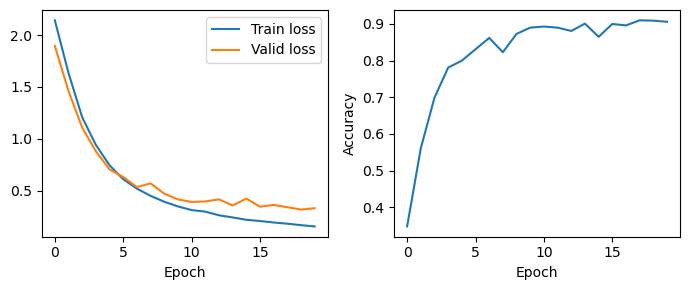

CPU times: user 53 s, sys: 6.35 s, total: 59.4 s
Wall time: 36.2 s


In [9]:
%%time
class Model(nn.Module):
    '''Modelo para classificação de dígitos.'''
    def __init__(self):
        super().__init__()

        # 12 filtros de convolução
        self.conv = nn.Conv2d(1, 12, kernel_size=13, padding=13//2) # equivariancia

        # Max pooling global que transforma a saída da convolução em 12 valores.
        # Cada valor representa a maior resposta do respectivo filtro.
        self.pool = nn.AdaptiveMaxPool2d(1) # invariancia

        # Camada linear que recebe 12 valores e gera 10 valores de saída
        self.fc = nn.Linear(12, 10) # fc = fully connected , camada linear

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        # Transformação do tensor de tamanho bs x 12 x 1 x 1 para bs x 12
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
    
model = Model()
logger = train.train(model, ds_train, ds_valid, bs=8, num_epochs=20, lr=0.01)

### Salvando e carregando a rede treinada

In [10]:
checkpoint = {
    'params':{
        'bs':8,
        'num_epochs':20,
        'lr':0.01
    },
    'model': model.state_dict() # função do PyTorch que devolve a NN utilizada, com os pesos/filtros/parametros.
}
torch.save(checkpoint, '../data/checkpoints/M04/mnist_model.pt') # pt = PyTorch

Após salvar a rede, podemos sempre ler novamente ela do disco:

In [15]:
checkpoint = torch.load('../data/checkpoints/M04/mnist_model.pt')
model = Model()
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Interpretação dos filtros gerados pela rede

A camada de convolução possui 12 filtros. Cada filtro possui tamanho 13x13. Podemos tentar entender o significado desses filtros

#### Visualização dos filtros

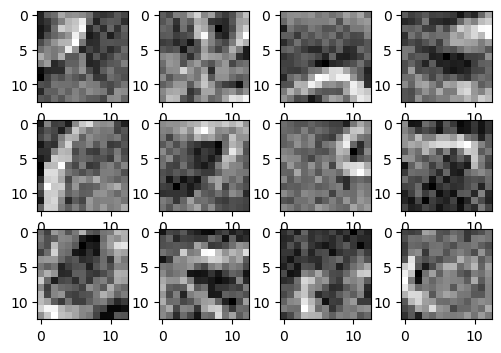

In [12]:
fig, axs = plt.subplots(3, 4, figsize = (6, 4))
axs = axs.reshape(-1)
for idx in range(12):
    axs[idx].imshow(model.conv.weight[idx, 0].detach(), 'gray')

#### Visualização da convolução entre imagens e cada filtro

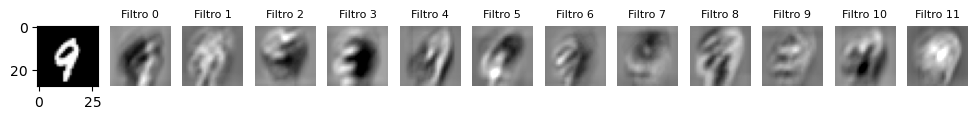

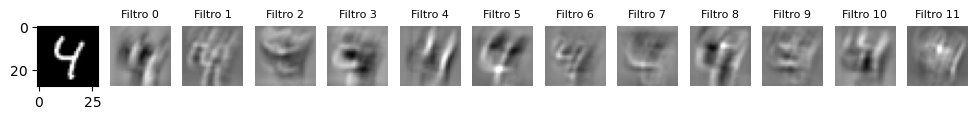

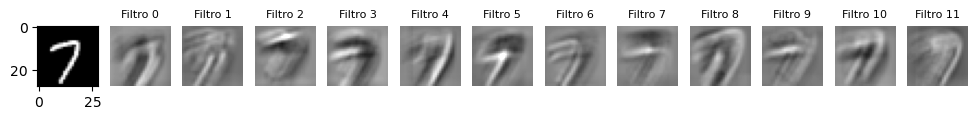

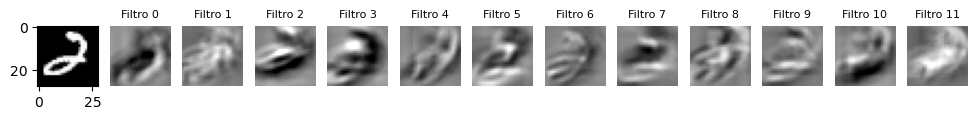

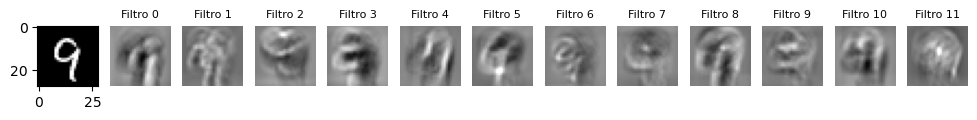

In [14]:
# Cria um batch de 5 imagens
n = 5
batch_images = torch.stack([ds_train[idx][0] for idx in range(n)])

# Aplica apenas a camada de convolução no batch
with torch.no_grad(): # Desabilita o cálculo de gradiente
    result = model.conv(batch_images)

# visualiza os 10 resultados para cada imagem
for idx in range(n):
    fig, axs = plt.subplots(1,13, figsize=(12,3))
    axs[0].imshow(batch_images[idx,0], 'gray')
    
    for channel in range(12):
        ax = axs[channel+1]
        ax.imshow(result[idx,channel], 'gray', vmin=-10, vmax=10)
        ax.set_title(f'Filtro {channel}', size=8)
        ax.set_axis_off()